In [1]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from IPython.display import Image
Image(url='../PwNY.gif', width = 900)

# Introduction

<p>In this notebook, I intent to use the Kaggle Advance House Problem to predict the price of a house based on its features. 

Just based on my intuition, the first thing that comes to my mind is that houses with more square footage will be more costly than the ones with less square footage. When I think harder, I realize that a 1000sq ft house in Boston downtown is not the same price as a 1000sq ft house in Greater Boston area. The complexity of the problem lies in various factors interacting with one another.</p>

<p>In this notebook, my main focus is to analyze factors that contribute in estimating a price of a house. Below are the few factors that I think we play significant role in house predictions are below</p>
<li>Square Footage</li>
<li>Locality</li>
<li>Proximity to schools</li>
<li>No. of rooms</li>
<li>Amneties</li>

<h3>Importing the packages needed for data analysis, regressor and visualization.</h3>

In [3]:
# Loading the packages needed
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
print('package have been loaded...')

package have been loaded...


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<h3>Loading the train and test</h3>

In [4]:
# Loading the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Saving the train id and the test id
train_id = train['Id']
test_id = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
print('Id field has been dropped')
print('Trainset Shape', train.shape)
print('Train/Test are loaded...')

Id field has been dropped
Trainset Shape (1460, 80)
Train/Test are loaded...


In [5]:
# Building a simple model using selected features
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h3>Imputing the missing features</h3>

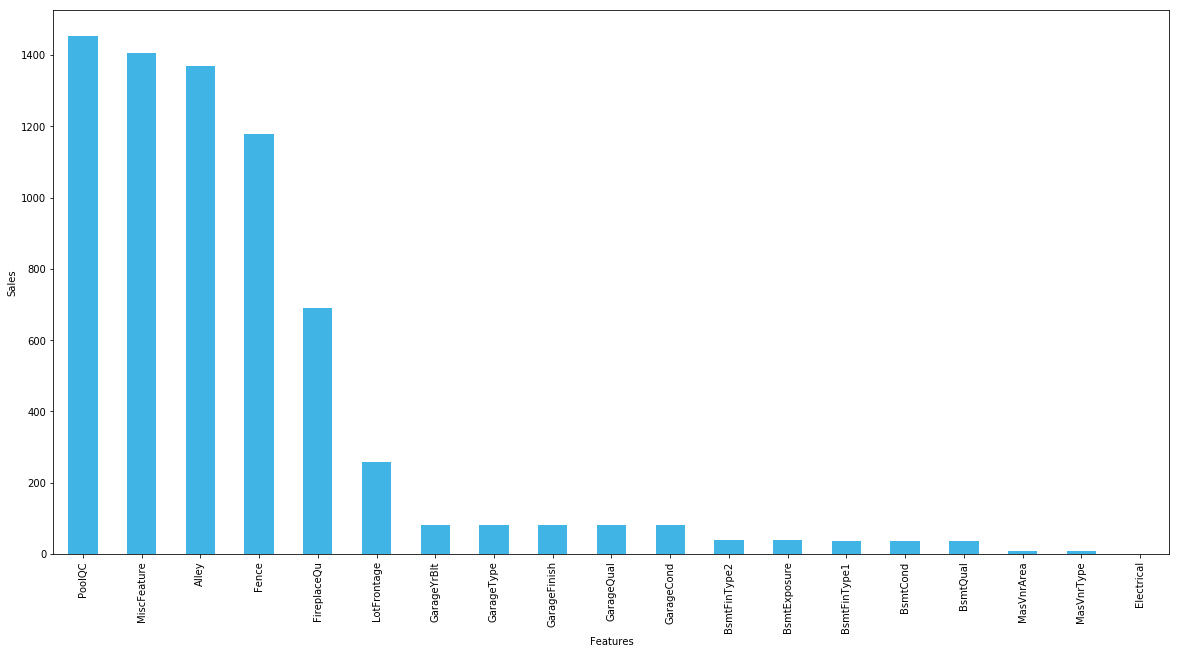

In [6]:
count_miss_train = train.isnull().sum()
count_miss_train = count_miss_train[count_miss_train!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
count_miss_train.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

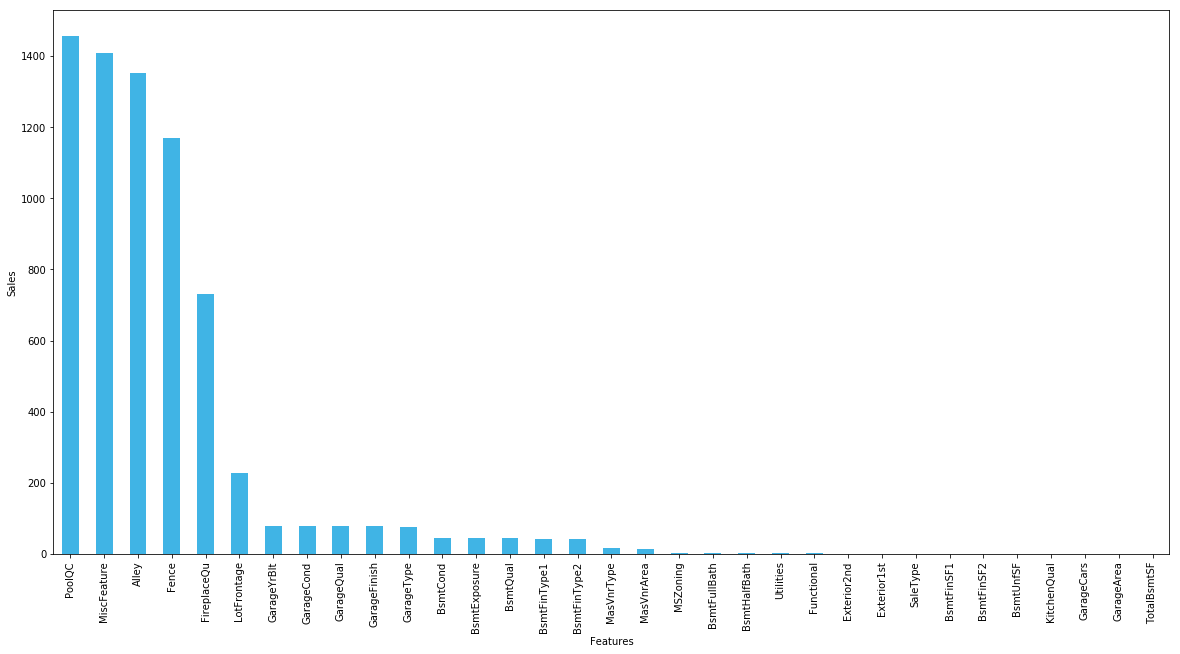

In [7]:
# Also, analyzing the missing data in testing set
count_miss_test = test.isnull().sum()
count_miss_test = count_miss_test[count_miss_test!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
count_miss_test.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

<p> For values which have lesser missing values, we will impute either by frequency (mode) if the feature is categorical, else, with mean / median if it is non categorical. For features with higher number of missing values, we will remove them</p>

<li>PoolQC - Pool Quality (can be removed)</li>
<li>MiscFeature: Miscellaneous feature not covered in other categories (can be removed</li>

In [8]:
# Combining the test and train data
train['Type'] = 'Train'
test['Type'] = 'Test'
housing = train.append(test)

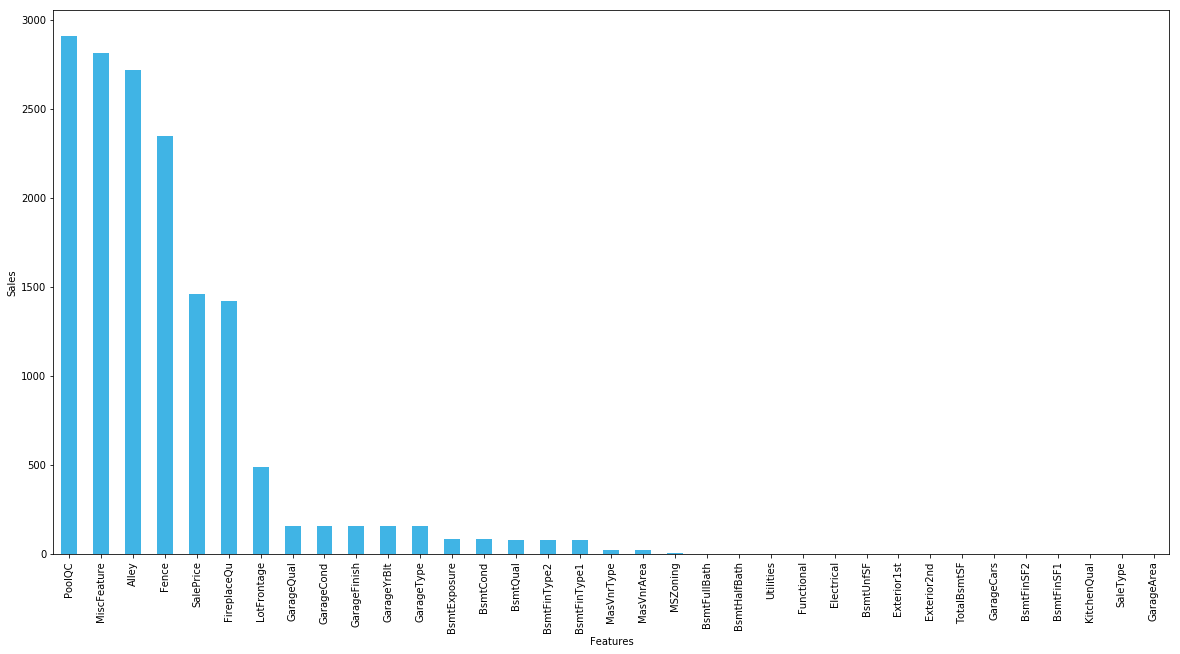

In [9]:
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
housing_miss.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

In [10]:
# Imputing with mode for below features
GarageQual_mode = housing[housing.GarageQual.notnull()]['GarageQual'].mode()[0]
housing['GarageQual'].fillna(GarageQual_mode,inplace=True)

GarageYrBlt_mode = housing[housing.GarageYrBlt.notnull()]['GarageYrBlt'].mode()[0]
housing['GarageYrBlt'].fillna(GarageYrBlt_mode,inplace=True)

GarageCond_mode = housing[housing.GarageCond.notnull()]['GarageCond'].mode()[0]
housing['GarageCond'].fillna(GarageCond_mode,inplace=True)

GarageFinish_mode = housing[housing.GarageFinish.notnull()]['GarageFinish'].mode()[0]
housing['GarageFinish'].fillna(GarageFinish_mode,inplace=True)

GarageType_mode = housing[housing.GarageType.notnull()]['GarageType'].mode()[0]
housing['GarageType'].fillna(GarageType_mode,inplace=True)

BsmtExposure_mode = housing[housing.BsmtExposure.notnull()]['BsmtExposure'].mode()[0]
housing['BsmtExposure'].fillna(BsmtExposure_mode,inplace=True)

BsmtCond_mode = housing[housing.BsmtCond.notnull()]['BsmtCond'].mode()[0]
housing['BsmtCond'].fillna(BsmtCond_mode,inplace=True)

BsmtQual_mode = housing[housing.BsmtQual.notnull()]['BsmtQual'].mode()[0]
housing['BsmtQual'].fillna(BsmtQual_mode,inplace=True)

BsmtFinType2_mode = housing[housing.BsmtFinType2.notnull()]['BsmtFinType2'].mode()[0]
housing['BsmtFinType2'].fillna(BsmtFinType2_mode,inplace=True)

BsmtFinType1_mode = housing[housing.BsmtFinType1.notnull()]['BsmtFinType1'].mode()[0]
housing['BsmtFinType1'].fillna(BsmtFinType1_mode,inplace=True)

MasVnrArea_mode = housing[housing.MasVnrArea.notnull()]['MasVnrArea'].median()
housing['MasVnrArea'].fillna(MasVnrArea_mode,inplace=True)

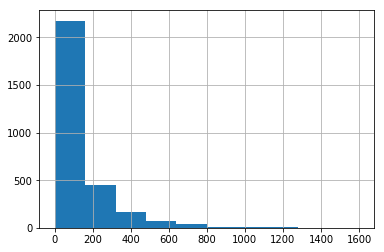

In [11]:
housing[housing.MasVnrArea.notnull()]['MasVnrArea'].hist()
plt.show()

Based on the histogram, we will keep the value as 0

In [12]:
MasVnrType_mode = housing[housing.MasVnrType.notnull()]['MasVnrType'].mode()[0]
housing['MasVnrType'].fillna(MasVnrType_mode,inplace=True)

BsmtCond_mode = housing[housing.BsmtCond.notnull()]['BsmtCond'].mode()[0]
housing['Electrical'].fillna(BsmtCond_mode,inplace=True)

BsmtQual_mode = housing[housing.BsmtQual.notnull()]['BsmtQual'].mode()[0]
housing['BsmtUnfSF'].fillna(BsmtQual_mode,inplace=True)

BsmtHalfBath_mode = housing[housing.BsmtHalfBath.notnull()]['BsmtHalfBath'].mode()[0]
housing['BsmtHalfBath'].fillna(BsmtHalfBath_mode,inplace=True)

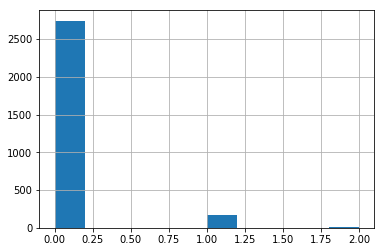

In [13]:
housing[housing.BsmtHalfBath.notnull()]['BsmtHalfBath'].hist()
plt.show()

Keeping this value as 0

In [14]:
BsmtFinType1_mode = housing[housing.BsmtFinType1.notnull()]['BsmtFinType1'].mode()[0]
housing['BsmtFinType1'].fillna(BsmtFinType1_mode,inplace=True)

Utilities_mode = housing[housing.Utilities.notnull()]['Utilities'].mode()[0]
housing['Utilities'].fillna(Utilities_mode,inplace=True)

Functional_mode = housing[housing.Functional.notnull()]['Functional'].mode()[0]
housing['Functional'].fillna(Functional_mode,inplace=True)

BsmtFinType1_mode = housing[housing.BsmtFinType1.notnull()]['BsmtFinType1'].mode()[0]
housing['BsmtFinType1'].fillna(BsmtFinType1_mode,inplace=True)

Exterior1st_mode = housing[housing.Exterior1st.notnull()]['Exterior1st'].mode()[0]
housing['Exterior1st'].fillna(Exterior1st_mode,inplace=True)

Exterior2nd_mode = housing[housing.Exterior2nd.notnull()]['Exterior2nd'].mode()[0]
housing['Exterior2nd'].fillna(Exterior2nd_mode,inplace=True)

TotalBsmtSF_mode = housing[housing.TotalBsmtSF.notnull()]['TotalBsmtSF'].median()
housing['TotalBsmtSF'].fillna(TotalBsmtSF_mode,inplace=True)

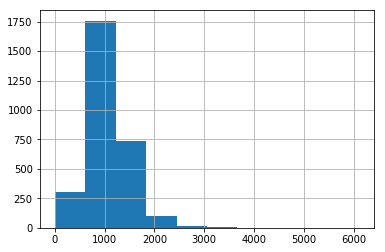

In [15]:
housing[housing.TotalBsmtSF.notnull()]['TotalBsmtSF'].hist()
plt.show()

Replacing with the median in this case.

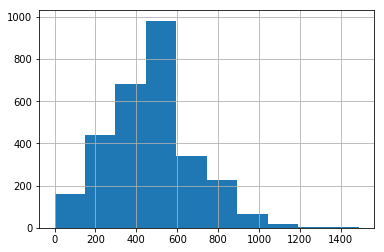

In [16]:
housing[housing.GarageArea.notnull()]['GarageArea'].hist()
plt.show()

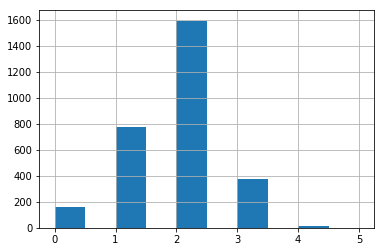

In [17]:
housing[housing.GarageCars.notnull()]['GarageCars'].hist()
plt.show()

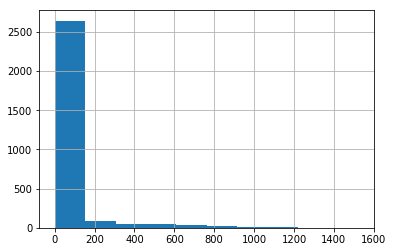

In [18]:
housing[housing.BsmtFinSF2.notnull()]['BsmtFinSF2'].hist()
plt.show()

In [19]:
GarageArea_mode = housing[housing.GarageArea.notnull()]['GarageArea'].median()
housing['GarageArea'].fillna(GarageArea_mode,inplace=True)

GarageCars_mode = housing[housing.GarageCars.notnull()]['GarageCars'].median()
housing['GarageCars'].fillna(GarageCars_mode,inplace=True)

SaleType_mode = housing[housing.SaleType.notnull()]['SaleType'].mode()[0]
housing['SaleType'].fillna(SaleType_mode,inplace=True)

KitchenQual_mode = housing[housing.KitchenQual.notnull()]['KitchenQual'].mode()[0]
housing['KitchenQual'].fillna(KitchenQual_mode,inplace=True)

BsmtFinSF2_mode = housing[housing.BsmtFinSF2.notnull()]['BsmtFinSF2'].median()
housing['BsmtFinSF2'].fillna(BsmtFinSF2_mode,inplace=True)

BsmtFinSF1_mode = housing[housing.BsmtFinSF1.notnull()]['BsmtFinSF1'].median()
housing['BsmtFinSF1'].fillna(BsmtFinSF1_mode,inplace=True)

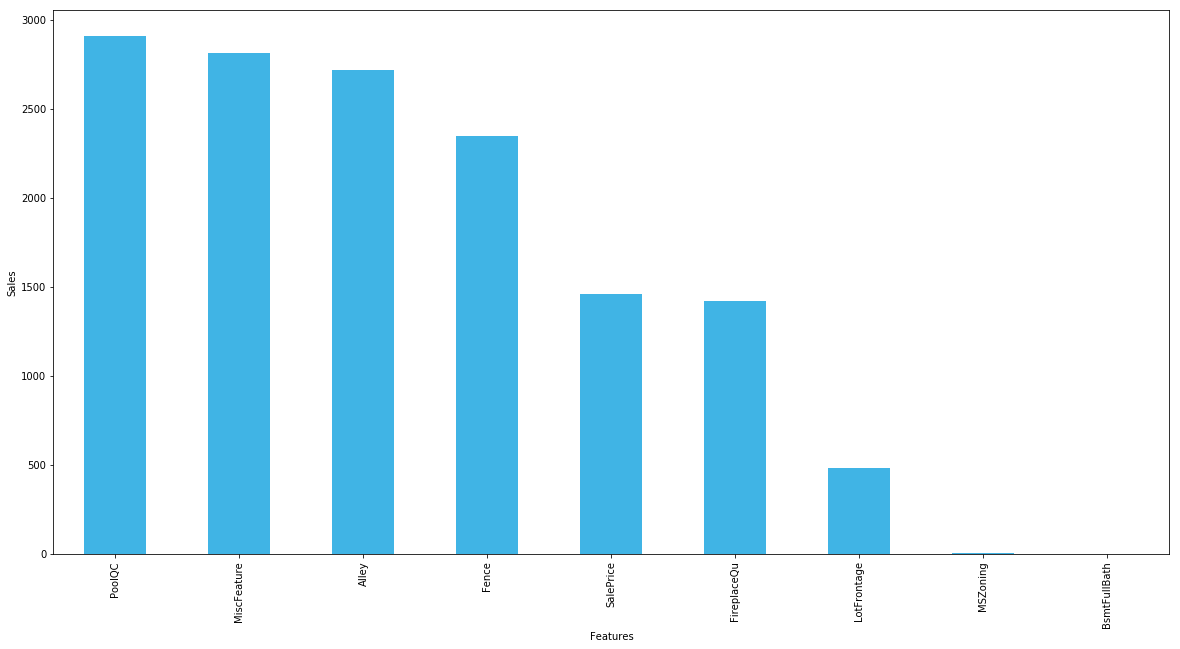

In [20]:
# Checking the missing values now
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
housing_miss.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

In [21]:
missing_cutoff = round(housing.shape[0] * 0.3,0)

feat_miss_cutoff = housing.isnull().sum()[housing.isnull().sum() > missing_cutoff].index[:].tolist()

housing.drop(feat_miss_cutoff, axis=1, inplace=True)

In [22]:
housing.isnull().sum()

1stFlrSF           0
2ndFlrSF           0
3SsnPorch          0
BedroomAbvGr       0
BldgType           0
BsmtCond           0
BsmtExposure       0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtFinType1       0
BsmtFinType2       0
BsmtFullBath       2
BsmtHalfBath       0
BsmtQual           0
BsmtUnfSF          0
CentralAir         0
Condition1         0
Condition2         0
Electrical         0
EnclosedPorch      0
ExterCond          0
ExterQual          0
Exterior1st        0
Exterior2nd        0
Fireplaces         0
Foundation         0
FullBath           0
Functional         0
GarageArea         0
GarageCars         0
                ... 
LotConfig          0
LotFrontage      486
LotShape           0
LowQualFinSF       0
MSSubClass         0
MSZoning           4
MasVnrArea         0
MasVnrType         0
MiscVal            0
MoSold             0
Neighborhood       0
OpenPorchSF        0
OverallCond        0
OverallQual        0
PavedDrive         0
PoolArea           0
RoofMatl     

In [23]:
feat_miss_cutoff

['Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC', 'SalePrice']

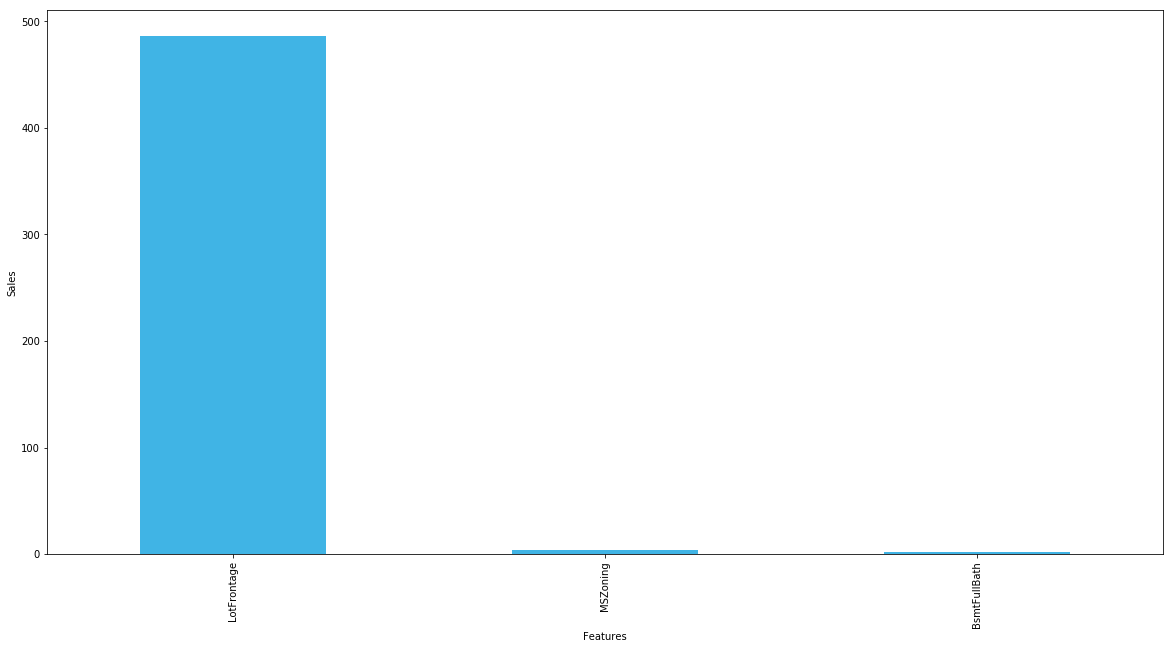

In [24]:
# Checking the missing values now
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)

plt.subplots(figsize =(20, 10))
housing_miss.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()

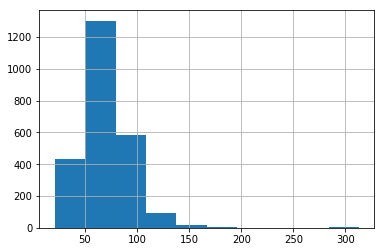

In [26]:
housing[housing.LotFrontage.notnull()]['LotFrontage'].hist()
plt.show()

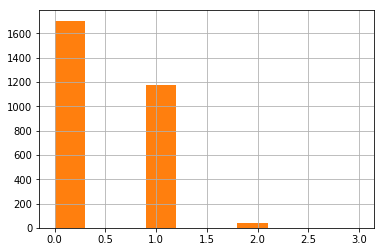

In [31]:
housing[housing.BsmtFullBath.notnull()]['BsmtFullBath'].hist()
plt.show()

In [32]:
LotFrontage_mode = housing[housing.LotFrontage.notnull()]['LotFrontage'].median()
housing['LotFrontage'].fillna(LotFrontage_mode,inplace=True)

MSZoning_mode = housing[housing.MSZoning.notnull()]['MSZoning'].mode()[0]
housing['MSZoning'].fillna(MSZoning_mode,inplace=True)

BsmtFullBath_mode = housing[housing.BsmtFullBath.notnull()]['BsmtFullBath'].median()
housing['BsmtFullBath'].fillna(BsmtFullBath_mode,inplace=True)

In [42]:
# Checking the missing values now
housing_miss = housing.isnull().sum()
housing_miss = housing_miss[housing_miss!=0].sort_values(ascending=False)
if (housing_miss.empty):
    print('All missing values treated!')
else:
    print('Error needs to be investigated!')

All missing values treated!


In [44]:
# Splitting the data again into train and test
train = housing[housing['Type']=='Train']
test = housing[housing['Type']=='Test']
train.drop(['Type'], axis=1, inplace=True)
test.drop(['Type'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
